In [ ]:
# %pip install -q pandas scikit-learn torch matplotlib

## Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## Data Ingestion

In [2]:
# setting random seeds for reproducibility
torch.manual_seed(42)

In [3]:
df = pd.read_csv("/content/fmnist_small.csv")
print(f"shape: {df.shape}")
df.head()

shape: (6000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


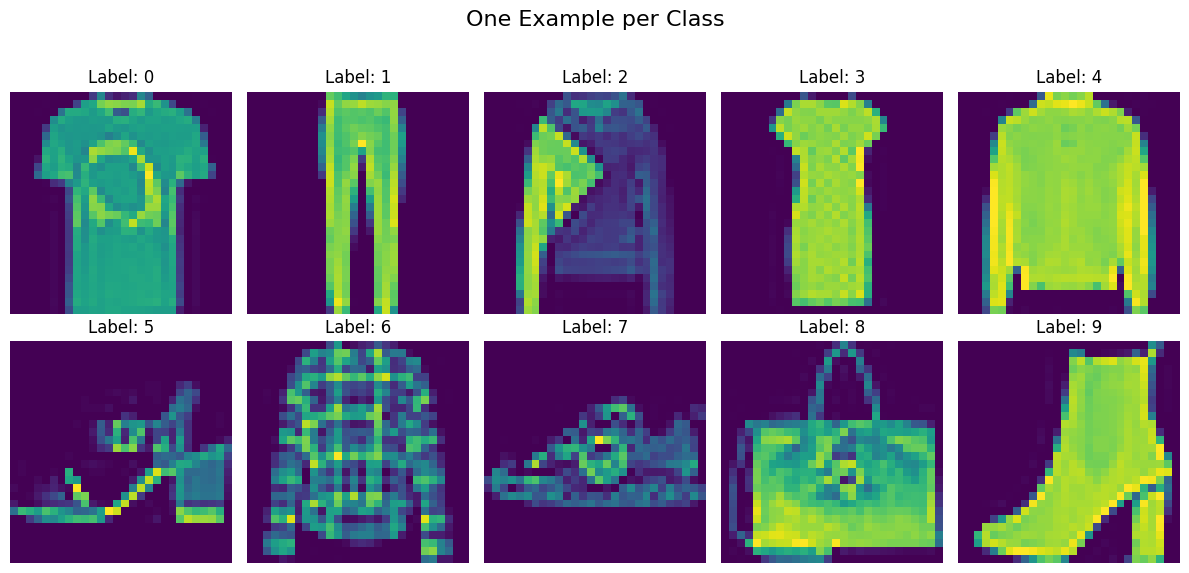

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("One Example per Class", fontsize=16)

# Loop through each class (0–9)
for cls, ax in enumerate(axes.flat):
    # Pick the first sample of this class
    img_row = df[df.iloc[:, 0] == cls].iloc[0]
    img = img_row[1:].values.reshape(28, 28)

    # Show the image
    ax.imshow(img, cmap="viridis")   # or "plasma", "inferno", "gray"
    ax.axis("off")
    ax.set_title(f"Label: {cls}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# scaling the feautures
X_train = X_train/255.0
X_test = X_test/255.0

In [8]:
X_train

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.0627451, 0.       ,
        0.       ]])

In [9]:
# create CustomDataset Class

class  CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32) # In PT, usually, features are expected to be of float32 type
        self.labels = torch.tensor(labels, dtype=torch.long) # In PT, usually, labels are expected to be of long type

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [10]:
# create train_dataset object
train_dataset = CustomDataset(X_train, y_train)

In [11]:
len(train_dataset)

4800

In [12]:
# create test_dataset object
test_dataset = CustomDataset(X_test, y_test)

In [13]:
len(test_dataset)

1200

In [14]:
# create train and test loaders

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## ANN Design

In [15]:
class ANN(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            # Softmax is not strictly necessary to implement in the output layer of a neural network
            # when using frameworks like TensorFlow or PyTorch because the cross-entropy loss functions
            # often internally incorporate the softmax calculation for numerical stability and efficiency.
        )

    def forward(self, X):
        """
        In PyTorch, when a torch.nn.Module instance is created, it becomes callable
        directly like a function. This is because the `__call__` method is implemented
        within the `torch.nn.Module` class, which handles the necessary setup and then
        internally invokes the forward method that you define.
        """
        return self.model(X)

## Training ANN

In [16]:
# set HyperParameters
epochs = 100
learning_rate = 0.1

In [17]:
# instantiate the model
model = ANN(input_features=X_train.shape[1])

# define loss fn
loss_fn = nn.CrossEntropyLoss()

# define optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
# The Training Loop
for epoch in range(epochs):
    epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        # forward pass
        outputs = model(batch_features)

        # calculate loss
        loss = loss_fn(outputs, batch_labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}")

Epoch 1/100, Loss: 1.3216368440786999
Epoch 2/100, Loss: 0.7793365436792373
Epoch 3/100, Loss: 0.6427524652083715
Epoch 4/100, Loss: 0.5751657336950302
Epoch 5/100, Loss: 0.528180201848348
Epoch 6/100, Loss: 0.49528750121593473
Epoch 7/100, Loss: 0.4602432996034622
Epoch 8/100, Loss: 0.4359459094206492
Epoch 9/100, Loss: 0.41829214423894884
Epoch 10/100, Loss: 0.3984092291692893
Epoch 11/100, Loss: 0.3850264506538709
Epoch 12/100, Loss: 0.3722685620188713
Epoch 13/100, Loss: 0.3477362078428268
Epoch 14/100, Loss: 0.3467242218057315
Epoch 15/100, Loss: 0.3138812760512034
Epoch 16/100, Loss: 0.3126461291313171
Epoch 17/100, Loss: 0.29552092105150224
Epoch 18/100, Loss: 0.2857150869568189
Epoch 19/100, Loss: 0.27084775785605114
Epoch 20/100, Loss: 0.26237100958824155
Epoch 21/100, Loss: 0.25756089876095456
Epoch 22/100, Loss: 0.24232648963729542
Epoch 23/100, Loss: 0.23957946779827277
Epoch 24/100, Loss: 0.2261324493587017
Epoch 25/100, Loss: 0.2233684351791938
Epoch 26/100, Loss: 0.21165

## ANN Evaluation

In [19]:
# set model to eval mode
model.eval()

ANN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [20]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs = model(batch_features)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = round((correct/total)*100, 2)
print(f"Accuracy: {accuracy}")

Accuracy: 83.25
